## 1. Read in the Data, Examine the First Row

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import poisson, kstest

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, year, month, dayofmonth, hour, dayofyear, weekofyear
from pyspark.sql.types import TimestampType, BooleanType
from datetime import datetime

spark = SparkSession.builder.getOrCreate()
df = spark.read.csv("/Users/joesphgartner/Projects/sprints/maximum-likelihood/data/", header='true',  inferSchema='true')
df.head()

Row(Traffic Report ID='8D4F80DF0D37819CDE3E3D2BB9982D111EBAC97C_1510929686000', Published Date='11/17/2017 02:41:00 PM +0000', Issue Reported='Crash Urgent', Location='(30.213998,-97.830319)', Latitude=30.213998, Longitude=-97.830319, Address='6900 BRODIE LN', Status='ARCHIVED', Status Date='11/17/2017 03:25:00 PM +0000')

## 2. Create a New Column with Datetime Objects

In [2]:
make_dt = udf(lambda date_string: datetime.strptime(date_string, "%m/%d/%Y %H:%M:%S %p %z"), TimestampType())
df = df.withColumn("dt_pub", make_dt(df['Published Date']))
df.head()

Row(Traffic Report ID='8D4F80DF0D37819CDE3E3D2BB9982D111EBAC97C_1510929686000', Published Date='11/17/2017 02:41:00 PM +0000', Issue Reported='Crash Urgent', Location='(30.213998,-97.830319)', Latitude=30.213998, Longitude=-97.830319, Address='6900 BRODIE LN', Status='ARCHIVED', Status Date='11/17/2017 03:25:00 PM +0000', dt_pub=datetime.datetime(2017, 11, 16, 20, 41))

## 3. Get the Unique 'Issue Reported' Types

In [3]:
df.select("Issue Reported").distinct().show()

+--------------------+
|      Issue Reported|
+--------------------+
|COLLISION WITH IN...|
|   BLOCKED DRIV/ HWY|
|  Traffic Impediment|
|       Crash Service|
|   TRFC HAZD/ DEBRIS|
|    zSTALLED VEHICLE|
|        VEHICLE FIRE|
|       BOAT ACCIDENT|
|        Crash Urgent|
|      Traffic Hazard|
|     LOOSE LIVESTOCK|
|    TRAFFIC FATALITY|
|    FLEET ACC/ FATAL|
|   COLLISN/ LVNG SCN|
|     COLLISN / FTSRA|
|         ICY ROADWAY|
|          HIGH WATER|
|           AUTO/ PED|
|  N / HZRD TRFC VIOL|
|           COLLISION|
+--------------------+
only showing top 20 rows



## 4. Create Slice
We'll be continually revisiting the 'LOOSE LIVESTOCK' type for year 2018, so we start by making a subset first.

In [4]:
df_livestock = df[(df["Issue Reported"]=='LOOSE LIVESTOCK') & (year(df['dt_pub'])==2018)]
df_ls_daily_counts = df_livestock.groupBy([year(df_livestock['dt_pub']), month(df_livestock['dt_pub']), dayofmonth(df_livestock['dt_pub'])]).count()
df_ls_daily_counts.show()

+------------+-------------+------------------+-----+
|year(dt_pub)|month(dt_pub)|dayofmonth(dt_pub)|count|
+------------+-------------+------------------+-----+
|        2018|            4|                 5|    3|
|        2018|            8|                15|    5|
|        2018|            6|                19|    3|
|        2018|            7|                 8|    4|
|        2018|           10|                30|    6|
|        2018|            2|                22|    1|
|        2018|            7|                 3|    2|
|        2018|            3|                 3|    1|
|        2018|            5|                28|    1|
|        2018|            6|                 3|    4|
|        2018|           12|                24|    2|
|        2018|            6|                22|    3|
|        2018|           11|                16|    1|
|        2018|            1|                13|    1|
|        2018|            8|                22|    2|
|        2018|           11|

## 5. Plot the Sum of Log Likelihoods for a Wide Range of Lambda Values

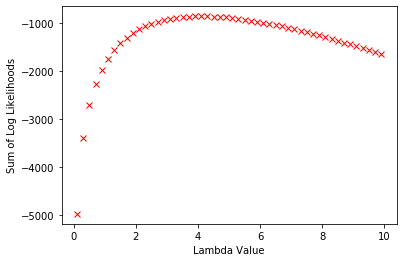

In [5]:
counts = [x.Count for x in df_ls_daily_counts.select(['Count']).collect()]
counts = counts + [0]*(365-len(counts))

def sum_log_likelihood(incidents, lam):
    return np.sum([poisson.logpmf(x, lam) for x in incidents])

_x = np.arange(.1, 10, step=.2)
_y = [sum_log_likelihood(counts, x) for x in _x]


fig, ax = plt.subplots()
ax.plot(_x, _y, 'rx')
ax.set_xlabel("Lambda Value")
_ = ax.set_ylabel("Sum of Log Likelihoods")

## 6. Run a KS Test & Visualize

In [6]:
mll_lambda = max(zip(_y,_x))[1]
kstest(counts, 'poisson', [mll_lambda])

KstestResult(statistic=0.1709521263778393, pvalue=8.520616900029789e-10)

Text(0, 0.5, 'Probability Density')

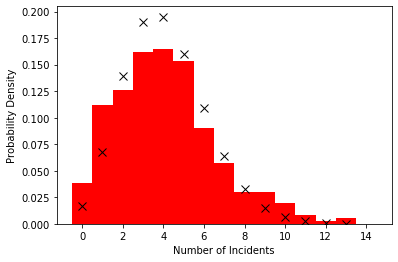

In [7]:
incident_range = [x for x in range(14)]
fig, ax = plt.subplots()
ax.hist(counts, bins = [x-.5 for x in range(16)], color='r', density=True, label='data')
ax.plot(incident_range, poisson.pmf(incident_range, mll_lambda), 'kx', ms=8, label='poisson pmf')
ax.set_xlabel("Number of Incidents")
ax.set_ylabel("Probability Density")

## 7. Create an 'is_weekday' Column

In [8]:
def local_is_weekday(dt):
    if dt.weekday() < 5:
        return True
    return False

is_weekday = udf(lambda date_obj: local_is_weekday(date_obj), BooleanType())
df_livestock = df_livestock.withColumn("is_weekday", is_weekday(df_livestock['dt_pub']))
df_livestock.head()

Row(Traffic Report ID='AA4D91CE2E5A36BB7D4BFC5C70DE0C6B781C3D1F_1540856864', Published Date='10/29/2018 11:47:44 PM +0000', Issue Reported='LOOSE LIVESTOCK', Location='(30.082065,-97.66622)', Latitude=30.082065, Longitude=-97.66622, Address='SCHRIBER RD & MAHA LOOP RD', Status='ARCHIVED', Status Date='10/30/2018 01:00:04 AM +0000', dt_pub=datetime.datetime(2018, 10, 29, 6, 47, 44), is_weekday=True)

## 8. Create Hourly Visualizations

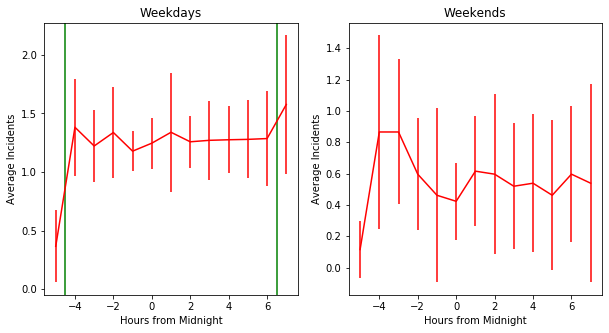

In [9]:
df_ls_wd = df_livestock[df_livestock['is_weekday']==True]
df_ls_we = df_livestock[df_livestock['is_weekday']==False]

df_ls_weekday_hour = df_ls_wd.groupBy([hour(df_ls_wd['dt_pub']), dayofyear(df_ls_wd['dt_pub'])]).count().withColumnRenamed("hour(dt_pub)", "hour").withColumnRenamed("count", "total").withColumnRenamed("dayofyear(dt_pub)", "day").collect()
df_ls_weekend_hour = df_ls_we.groupBy([hour(df_ls_we['dt_pub']), dayofyear(df_ls_we['dt_pub'])]).count().withColumnRenamed("hour(dt_pub)", "hour").withColumnRenamed("count", "total").withColumnRenamed("dayofyear(dt_pub)", "day").collect()

def map_back(hour):
    if hour < 0:
        return hour+24
    return hour

def hourly_stats(count_arr):
    hours = [x for x in range(-5, 8)]
    hourly_totals = [[x.total for x in count_arr if x.hour==map_back(hour)] for hour in hours]
    hourly_totals = [x + [0]*(52-len(x)) for x in hourly_totals]
    hourly_averages = [np.mean(x) for x in hourly_totals]
    hourly_error = [np.var(x) for x in hourly_totals]
    return hours, hourly_averages, hourly_error

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
hours, hourly_averages, hourly_error = hourly_stats(df_ls_weekday_hour)
ax[0].errorbar(hours, hourly_averages, yerr=hourly_error, c='r')
ax[0].axvline(-4.5, c='g')
ax[0].axvline(6.5, c='g')
ax[0].set_xlabel("Hours from Midnight")
ax[0].set_ylabel("Average Incidents")
ax[0].set_title("Weekdays")
hours, hourly_averages, hourly_error = hourly_stats(df_ls_weekend_hour)
ax[1].errorbar(hours, hourly_averages, yerr=hourly_error, c='r')
ax[1].set_xlabel("Hours from Midnight")
ax[1].set_ylabel("Average Incidents")
_ = ax[1].set_title("Weekends")

# 9. Create Weekly Counts

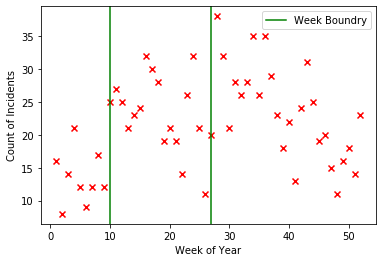

In [10]:
df_ls_byweek = df_ls_wd.groupBy([weekofyear(df_ls_wd['dt_pub'])]).count().withColumnRenamed("weekofyear(dt_pub)", "week").withColumnRenamed("count", "total")

week_dict = df_ls_byweek.toPandas().set_index('week').T.to_dict('list')
weeks = [x for x in range(1,53)]
fig, ax = plt.subplots()
ax.scatter(weeks, [week_dict.get(week, [0])[0] for week in weeks], c='r', marker='x')
ax.axvline(10, c='g', label="Week Boundry")
ax.axvline(27, c='g')
ax.set_xlabel("Week of Year")
ax.set_ylabel("Count of Incidents")
_ = ax.legend()

## 10. Create a Stable Subset, Rerun MLE

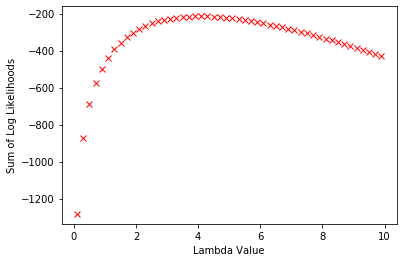

In [11]:
df_sub = df_ls_wd[(weekofyear(df_ls_wd['dt_pub'])>9) \
         & (weekofyear(df_ls_wd['dt_pub'])<28) \
         & ((hour(df_ls_wd['dt_pub']) < 7) | (hour(df_ls_wd['dt_pub']) > 19))]
    
sub_daily_counts = df_sub.groupBy([year(df_sub['dt_pub']), month(df_sub['dt_pub']), dayofmonth(df_sub['dt_pub'])]).count()
    

counts = [x.Count for x in sub_daily_counts.select(['Count']).collect()]
counts = counts + [0]*(85-len(counts))
_x = np.arange(.1, 10, step=.2)
_y = [sum_log_likelihood(counts, x) for x in _x]

fig, ax = plt.subplots()
ax.plot(_x, _y, 'rx')
ax.set_xlabel("Lambda Value")
_ = ax.set_ylabel("Sum of Log Likelihoods")

## 11. Check if this Subset is a Better Fit

In [12]:
mll_lambda = max(zip(_y,_x))[1]
kstest(counts, 'poisson', [mll_lambda])

KstestResult(statistic=0.1358310260643324, pvalue=0.050606568898742564)

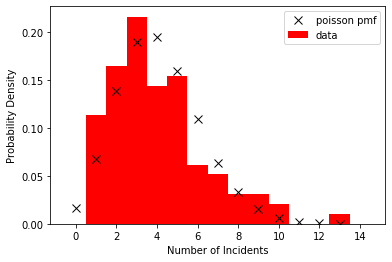

In [13]:
incident_range = [x for x in range(14)]
fig, ax = plt.subplots()
ax.hist(counts, bins = [x-.5 for x in range(16)], color='r', density=True, label='data')
ax.plot(incident_range, poisson.pmf(incident_range, mll_lambda), 'kx', ms=8, label='poisson pmf')
ax.set_xlabel("Number of Incidents")
ax.set_ylabel("Probability Density")
_ = ax.legend()

## Take Aways
We can see that the Poisson Distribution and MLE have very specific assumptions baked in, and that our data may not adhere to these assumptions well.  The built in requirement for data to be IID is one that we need to verify, and takes effort, particularly on time ordered data.  

Intuition may have signaled that traffic accidents of a particular variety might have been a good fit for this model, but it seems that due to the complex nature of traffic systems, we might need a more dynamic model.

Another key takeaway here is the importance of visualizations.  If you have a test such as KS being your default mechanism for goodness of fit, you might be willing to accept the model with the final window.  Visualizing the PMF over the data should make us second guess this.  It doesn't mean that a KS test doesn't have value in assessing a models viablitity, but visualization will continue to be a very important tool for determining the viability of a test.